# This notebook implements sleeper agent attack

In this notebook, we will learn how to use ART to run a Hidden Trigger Backdoor Attack Sleeper Agent poisoning attack on a neural network trained with Pytorch. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/pdf/2106.08970.pdf) by Hossein Souri, et. al. 2021.

In [1]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Data Normalization and Substitute Model Training 

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

patch_size = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = Image.open('trigger_10.png')
numpydata = asarray(img)
patch = resize(numpydata, (patch_size,patch_size,3))
patch = (patch-mean)/(std+1e-7)

In [4]:
def testAccuracy(model, test_loader):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

In [5]:
def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25):
    initial_conv = [3, 1, 1]
    model = torchvision.models.ResNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    
    # Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    x_train = np.transpose(x_train, [0, 3,1,2])
    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
    
    x_test = np.transpose(x_test, [0, 3,1,2])
    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    for epoch in trange(epochs):
        running_loss = 0.0
        total = 0
        accuracy = 0
        for i, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # _, predicted = torch.max(outputs.data, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (100 * accuracy / total)
        print("Epoch %d train accuracy: %f" % (epoch, train_accuracy))
        test_accuracy = testAccuracy(model, dataloader_test)
        print("Final test accuracy: %f" % test_accuracy)
    return model, loss_fn, optimizer

# Train Substitute Model for Attack

In [6]:
model_path = "cifar10-resnet18-pytorch.pth"
if not os.path.exists(model_path):
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=80)
    torch.save(model.state_dict(), model_path)
else:
    print("Pretrained model exists")
    model, loss_fn, optimizer = create_model(x_train, y_train,x_test=x_test,y_test=y_test,epochs=0)
    model.load_state_dict(torch.load(model_path))

Pretrained model exists


0it [00:00, ?it/s]


# Select Triggers from Source Class and helper functions for calculating Success Rate

In [7]:
model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)
from art.utils import to_categorical
from art.attacks.poisoning.sleeper_agent_attack import SleeperAgentAttack

def select_trigger_train(x_train,y_train,K):
    x_train_ = np.copy(x_train)
    class_source = 0
    class_target = 1
    index_source = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
    index_target = np.where(y_train.argmax(axis=1)==class_target)[0]
    x_trigger = x_train_[index_source]
    y_trigger  = to_categorical([class_target], nb_classes=10)
    y_trigger = np.tile(y_trigger,(len(index_source),1))
    x_samples = x_train_[index_target]
    y_samples = y_train[index_target]
    return x_trigger,y_trigger,x_samples,y_samples,class_source,class_target,index_target
   

# Generate Poison Images through attack 

In [8]:
x_trigger,y_trigger,x_samples,y_samples,class_source,class_target,index_target = select_trigger_train(x_train,y_train,1000)
result_original = model_art.predict(torch.tensor(np.transpose(x_trigger, [0, 3,1,2]), dtype=torch.float32))

In [9]:
attack = SleeperAgentAttack(model_art,
                                percent_poison=0.10,
                                max_trials=1,
                                max_epochs=250,
                                learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
                                clip_values=(min_,max_),
                                epsilon=16/255 * (max_ - min_),
                                batch_size=500,
                                verbose=1,
                                indices_target=index_target,
                                patching_strategy="random",
                                selection_strategy="max-norm",
                                patch=patch,
                                retraining_factor = 4,
                                model_retrain = True,
                                model_retraining_epoch = 80
                           )
x_poison, y_poison = attack.poison(x_trigger, 
                                                   y_trigger, 
                                                   torch.tensor(np.transpose(x_samples, [0, 3,1,2]), dtype=torch.float32), 
                                                   y_samples)
indices_poison = attack.get_poison_indices()
x_poison = np.transpose(x_poison, [0,2,3,1])
x_poison_ = np.copy(x_train)
x_poison_[index_target[indices_poison]]=x_poison[indices_poison]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/shritipriya/anaconda3/envs/art/lib/python3.8/site-packages/art/attacks/poisoning/gradient_matching_attack.py:342: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(x_trigger, device=device, dtype=torch.float32),


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 37.666
Epoch 5 train accuracy: 76.21
Epoch 10 train accuracy: 83.194
Epoch 15 train accuracy: 86.288
Epoch 20 train accuracy: 87.49
Epoch 25 train accuracy: 88.144
Epoch 30 train accuracy: 89.096
Epoch 35 train accuracy: 89.25
Epoch 40 train accuracy: 89.494
Epoch 45 train accuracy: 89.642
Epoch 50 train accuracy: 89.982
Epoch 55 train accuracy: 89.994
Epoch 60 train accuracy: 90.3
Epoch 65 train accuracy: 90.194
Epoch 70 train accuracy: 90.144
Epoch 75 train accuracy: 90.084
Epoch 79 train accuracy: 90.108
Final test accuracy: 71.31


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 36.556
Epoch 5 train accuracy: 75.914
Epoch 10 train accuracy: 83.024
Epoch 15 train accuracy: 86.13
Epoch 20 train accuracy: 87.58
Epoch 25 train accuracy: 88.384
Epoch 30 train accuracy: 88.774
Epoch 35 train accuracy: 88.922
Epoch 40 train accuracy: 89.362
Epoch 45 train accuracy: 89.61
Epoch 50 train accuracy: 89.748
Epoch 55 train accuracy: 89.924
Epoch 60 train accuracy: 89.87
Epoch 65 train accuracy: 90.172
Epoch 70 train accuracy: 90.294
Epoch 75 train accuracy: 90.212
Epoch 79 train accuracy: 90.102
Final test accuracy: 71.27


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 36.164
Epoch 5 train accuracy: 76.202
Epoch 10 train accuracy: 83.174
Epoch 15 train accuracy: 86.218
Epoch 20 train accuracy: 87.544
Epoch 25 train accuracy: 88.51
Epoch 30 train accuracy: 88.776
Epoch 35 train accuracy: 89.41
Epoch 40 train accuracy: 89.51
Epoch 45 train accuracy: 89.474
Epoch 50 train accuracy: 89.804
Epoch 55 train accuracy: 89.81
Epoch 60 train accuracy: 89.904
Epoch 65 train accuracy: 89.874
Epoch 70 train accuracy: 90.012
Epoch 75 train accuracy: 90.264
Epoch 79 train accuracy: 90.098
Final test accuracy: 72.92


  0%|          | 0/64 [00:00<?, ?it/s]

Best B-score: 0.021450936794281006


# Success Rate on Train Triggers

In [10]:
model_poisoned, loss_fn, optimizer = create_model(x_poison_,y_train,x_test=x_test,y_test=y_test,epochs=80)
model_poisoned.eval()

  0%|                                                                                                                                                                                                                                   | 0/80 [00:00<?, ?it/s]

Epoch 0 train accuracy: 31.084000


  1%|██▋                                                                                                                                                                                                                        | 1/80 [00:06<08:39,  6.57s/it]

Final test accuracy: 44.710000
Epoch 1 train accuracy: 51.252000


  2%|█████▍                                                                                                                                                                                                                     | 2/80 [00:13<08:32,  6.57s/it]

Final test accuracy: 55.550000
Epoch 2 train accuracy: 60.974000


  4%|████████▏                                                                                                                                                                                                                  | 3/80 [00:19<08:25,  6.56s/it]

Final test accuracy: 62.360000
Epoch 3 train accuracy: 67.748000


  5%|██████████▉                                                                                                                                                                                                                | 4/80 [00:26<08:18,  6.56s/it]

Final test accuracy: 66.200000
Epoch 4 train accuracy: 71.954000


  6%|█████████████▋                                                                                                                                                                                                             | 5/80 [00:32<08:12,  6.56s/it]

Final test accuracy: 66.970000
Epoch 5 train accuracy: 74.790000


  8%|████████████████▍                                                                                                                                                                                                          | 6/80 [00:39<08:05,  6.56s/it]

Final test accuracy: 66.940000
Epoch 6 train accuracy: 77.114000


  9%|███████████████████▏                                                                                                                                                                                                       | 7/80 [00:45<07:59,  6.56s/it]

Final test accuracy: 67.700000
Epoch 7 train accuracy: 78.892000


 10%|█████████████████████▉                                                                                                                                                                                                     | 8/80 [00:52<07:52,  6.56s/it]

Final test accuracy: 69.090000
Epoch 8 train accuracy: 80.596000


 11%|████████████████████████▋                                                                                                                                                                                                  | 9/80 [00:59<07:45,  6.56s/it]

Final test accuracy: 69.340000
Epoch 9 train accuracy: 81.824000


 12%|███████████████████████████▎                                                                                                                                                                                              | 10/80 [01:05<07:39,  6.56s/it]

Final test accuracy: 69.320000
Epoch 10 train accuracy: 82.900000


 14%|█████████████████████████████▉                                                                                                                                                                                            | 11/80 [01:12<07:32,  6.56s/it]

Final test accuracy: 69.240000
Epoch 11 train accuracy: 83.662000


 15%|████████████████████████████████▋                                                                                                                                                                                         | 12/80 [01:18<07:26,  6.56s/it]

Final test accuracy: 66.770000
Epoch 12 train accuracy: 84.516000


 16%|███████████████████████████████████▍                                                                                                                                                                                      | 13/80 [01:25<07:19,  6.56s/it]

Final test accuracy: 68.580000
Epoch 13 train accuracy: 84.882000


 18%|██████████████████████████████████████▏                                                                                                                                                                                   | 14/80 [01:31<07:13,  6.56s/it]

Final test accuracy: 68.880000
Epoch 14 train accuracy: 85.696000


 19%|████████████████████████████████████████▉                                                                                                                                                                                 | 15/80 [01:38<07:06,  6.56s/it]

Final test accuracy: 69.150000
Epoch 15 train accuracy: 85.918000


 20%|███████████████████████████████████████████▌                                                                                                                                                                              | 16/80 [01:45<07:00,  6.56s/it]

Final test accuracy: 70.550000
Epoch 16 train accuracy: 86.386000


 21%|██████████████████████████████████████████████▎                                                                                                                                                                           | 17/80 [01:51<06:53,  6.56s/it]

Final test accuracy: 68.430000
Epoch 17 train accuracy: 86.642000


 22%|█████████████████████████████████████████████████                                                                                                                                                                         | 18/80 [01:58<06:46,  6.56s/it]

Final test accuracy: 67.520000
Epoch 18 train accuracy: 87.022000


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                      | 19/80 [02:04<06:40,  6.56s/it]

Final test accuracy: 68.750000
Epoch 19 train accuracy: 87.190000


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                   | 20/80 [02:11<06:33,  6.56s/it]

Final test accuracy: 69.310000
Epoch 20 train accuracy: 87.500000


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                | 21/80 [02:17<06:27,  6.56s/it]

Final test accuracy: 66.400000
Epoch 21 train accuracy: 87.656000


 28%|███████████████████████████████████████████████████████████▉                                                                                                                                                              | 22/80 [02:24<06:20,  6.56s/it]

Final test accuracy: 69.950000
Epoch 22 train accuracy: 87.990000


 29%|██████████████████████████████████████████████████████████████▋                                                                                                                                                           | 23/80 [02:30<06:14,  6.56s/it]

Final test accuracy: 70.930000
Epoch 23 train accuracy: 88.154000


 30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 24/80 [02:37<06:07,  6.56s/it]

Final test accuracy: 70.320000
Epoch 24 train accuracy: 87.850000


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 25/80 [02:44<06:01,  6.56s/it]

Final test accuracy: 70.250000
Epoch 25 train accuracy: 88.242000


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 26/80 [02:50<05:54,  6.56s/it]

Final test accuracy: 70.580000
Epoch 26 train accuracy: 88.500000


 34%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 27/80 [02:57<05:47,  6.56s/it]

Final test accuracy: 70.400000
Epoch 27 train accuracy: 88.562000


 35%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 28/80 [03:03<05:41,  6.56s/it]

Final test accuracy: 69.870000
Epoch 28 train accuracy: 88.584000


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 29/80 [03:10<05:34,  6.56s/it]

Final test accuracy: 71.330000
Epoch 29 train accuracy: 88.800000


 38%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 30/80 [03:16<05:28,  6.56s/it]

Final test accuracy: 70.090000
Epoch 30 train accuracy: 88.764000


 39%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 31/80 [03:23<05:21,  6.56s/it]

Final test accuracy: 72.230000
Epoch 31 train accuracy: 88.830000


 40%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 32/80 [03:30<05:15,  6.56s/it]

Final test accuracy: 72.440000
Epoch 32 train accuracy: 88.924000


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 33/80 [03:36<05:08,  6.56s/it]

Final test accuracy: 70.960000
Epoch 33 train accuracy: 89.114000


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 34/80 [03:43<05:01,  6.56s/it]

Final test accuracy: 71.310000
Epoch 34 train accuracy: 89.014000


 44%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 35/80 [03:49<04:55,  6.56s/it]

Final test accuracy: 70.690000
Epoch 35 train accuracy: 89.058000


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 36/80 [03:56<04:48,  6.56s/it]

Final test accuracy: 70.480000
Epoch 36 train accuracy: 89.262000


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 37/80 [04:02<04:42,  6.56s/it]

Final test accuracy: 69.410000
Epoch 37 train accuracy: 89.104000


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 38/80 [04:09<04:35,  6.56s/it]

Final test accuracy: 71.090000
Epoch 38 train accuracy: 89.002000


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 39/80 [04:15<04:29,  6.56s/it]

Final test accuracy: 71.310000
Epoch 39 train accuracy: 89.570000


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 40/80 [04:22<04:22,  6.56s/it]

Final test accuracy: 69.210000
Epoch 40 train accuracy: 89.494000


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 41/80 [04:29<04:15,  6.56s/it]

Final test accuracy: 68.680000
Epoch 41 train accuracy: 89.518000


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 42/80 [04:35<04:09,  6.56s/it]

Final test accuracy: 71.930000
Epoch 42 train accuracy: 89.568000


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 43/80 [04:42<04:02,  6.56s/it]

Final test accuracy: 71.760000
Epoch 43 train accuracy: 89.430000


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 44/80 [04:48<03:56,  6.56s/it]

Final test accuracy: 70.590000
Epoch 44 train accuracy: 89.512000


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 45/80 [04:55<03:49,  6.56s/it]

Final test accuracy: 71.110000
Epoch 45 train accuracy: 89.436000


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 46/80 [05:01<03:43,  6.56s/it]

Final test accuracy: 71.130000
Epoch 46 train accuracy: 89.718000


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 47/80 [05:08<03:36,  6.56s/it]

Final test accuracy: 70.090000
Epoch 47 train accuracy: 89.302000


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 48/80 [05:15<03:29,  6.56s/it]

Final test accuracy: 71.290000
Epoch 48 train accuracy: 89.628000


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 49/80 [05:21<03:23,  6.56s/it]

Final test accuracy: 70.010000
Epoch 49 train accuracy: 89.434000


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 50/80 [05:28<03:16,  6.56s/it]

Final test accuracy: 71.120000
Epoch 50 train accuracy: 89.878000


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 51/80 [05:34<03:10,  6.55s/it]

Final test accuracy: 70.960000
Epoch 51 train accuracy: 89.814000


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 52/80 [05:41<03:03,  6.55s/it]

Final test accuracy: 70.790000
Epoch 52 train accuracy: 89.976000


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 53/80 [05:47<02:56,  6.55s/it]

Final test accuracy: 70.920000
Epoch 53 train accuracy: 89.880000


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 54/80 [05:54<02:50,  6.55s/it]

Final test accuracy: 71.310000
Epoch 54 train accuracy: 89.808000


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 55/80 [06:00<02:43,  6.55s/it]

Final test accuracy: 71.300000
Epoch 55 train accuracy: 89.786000


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 56/80 [06:07<02:37,  6.55s/it]

Final test accuracy: 71.890000
Epoch 56 train accuracy: 90.100000


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 57/80 [06:13<02:30,  6.55s/it]

Final test accuracy: 70.290000
Epoch 57 train accuracy: 90.100000


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 58/80 [06:20<02:24,  6.55s/it]

Final test accuracy: 71.070000
Epoch 58 train accuracy: 89.836000


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 59/80 [06:27<02:17,  6.55s/it]

Final test accuracy: 72.160000
Epoch 59 train accuracy: 89.736000


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 60/80 [06:33<02:10,  6.55s/it]

Final test accuracy: 70.190000
Epoch 60 train accuracy: 90.112000


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 61/80 [06:40<02:04,  6.55s/it]

Final test accuracy: 71.400000
Epoch 61 train accuracy: 90.052000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 62/80 [06:46<01:57,  6.55s/it]

Final test accuracy: 70.940000
Epoch 62 train accuracy: 89.950000


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 63/80 [06:53<01:51,  6.55s/it]

Final test accuracy: 72.120000
Epoch 63 train accuracy: 89.990000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 64/80 [06:59<01:44,  6.55s/it]

Final test accuracy: 71.410000
Epoch 64 train accuracy: 90.134000


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 65/80 [07:06<01:38,  6.55s/it]

Final test accuracy: 71.500000
Epoch 65 train accuracy: 89.966000


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 66/80 [07:12<01:31,  6.55s/it]

Final test accuracy: 72.360000
Epoch 66 train accuracy: 90.188000


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 67/80 [07:19<01:25,  6.55s/it]

Final test accuracy: 72.070000
Epoch 67 train accuracy: 90.016000


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 68/80 [07:26<01:18,  6.55s/it]

Final test accuracy: 71.380000
Epoch 68 train accuracy: 90.282000


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 69/80 [07:32<01:12,  6.55s/it]

Final test accuracy: 71.380000
Epoch 69 train accuracy: 90.116000


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 70/80 [07:39<01:05,  6.55s/it]

Final test accuracy: 72.050000
Epoch 70 train accuracy: 90.108000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 71/80 [07:45<00:58,  6.55s/it]

Final test accuracy: 72.410000
Epoch 71 train accuracy: 90.224000


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 72/80 [07:52<00:52,  6.55s/it]

Final test accuracy: 70.730000
Epoch 72 train accuracy: 90.102000


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 73/80 [07:58<00:45,  6.55s/it]

Final test accuracy: 71.320000
Epoch 73 train accuracy: 90.256000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 74/80 [08:05<00:39,  6.55s/it]

Final test accuracy: 72.160000
Epoch 74 train accuracy: 90.252000


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 75/80 [08:11<00:32,  6.55s/it]

Final test accuracy: 72.340000
Epoch 75 train accuracy: 90.164000


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 76/80 [08:18<00:26,  6.55s/it]

Final test accuracy: 72.780000
Epoch 76 train accuracy: 90.056000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 77/80 [08:24<00:19,  6.55s/it]

Final test accuracy: 70.280000
Epoch 77 train accuracy: 90.360000


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 78/80 [08:31<00:13,  6.55s/it]

Final test accuracy: 71.560000
Epoch 78 train accuracy: 90.096000


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 79/80 [08:38<00:06,  6.55s/it]

Final test accuracy: 73.060000
Epoch 79 train accuracy: 90.400000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [08:44<00:00,  6.56s/it]

Final test accuracy: 72.290000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Visualize Trigger, Original and Poisoned Images 

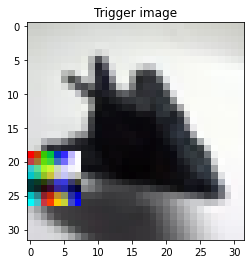

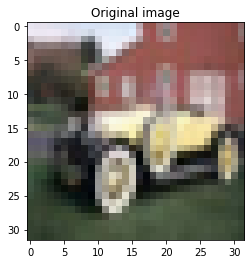

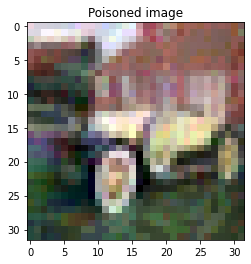

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison_[index_target[indices_poison][0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()

# Calculate Success Rate on x_train and x_test

In [12]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def add_trigger_patch(x_set,patch_type="fixed"):
    img = Image.open('trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (8,8,3))
    patch = (patch-mean)/(std+1e-7)
    if patch_type == "fixed":
        x_set[:,-patch_size:,-patch_size:,:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size,:]=patch

    return x_set

# Calculate on train images

5000
Train Success Rate 0.467


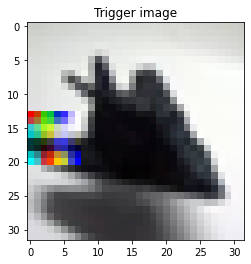

In [13]:
index_source_train = np.where(y_train.argmax(axis=1)==class_source)[0]
x_train_trigger = x_train[index_source_train]
x_train_trigger = add_trigger_patch(x_train_trigger,"random")
result_poisoned_train = model_poisoned(torch.tensor(np.transpose(x_train_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_train))

success_train = (np.argmax(result_poisoned_train,axis=1)==1).sum()/result_poisoned_train.shape[0]
print("Train Success Rate",success_train)
plt.imshow(x_train_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

# Calculate Success Rate on Test 

1000
Test Success Rate: 0.451


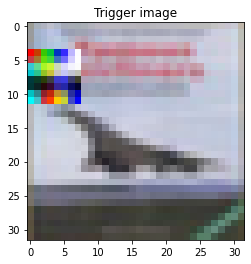

In [14]:
index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"random")
result_poisoned_test = model_poisoned(torch.tensor(np.transpose(x_test_trigger, [0,3,1,2]), device=device, dtype=torch.float)).detach().cpu().numpy()
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==1).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(x_test_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()